## 作業
最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練 CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)



In [0]:
import keras
import keras.backend as K
import numpy as np

K.clear_session()

In [9]:
# 讀取資料集
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
# 前處理
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(x_train)

In [0]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 35:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate

In [13]:
from keras.applications.resnet import ResNet50
conv_base = ResNet50(include_top=False, weights='imagenet',  input_shape=(128, 128, 3))
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
# from keras import models, layers
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Dropout, UpSampling2D, BatchNormalization
from keras.models import Model

batch_size_4_gen = 256
num_classes = 10
epochs = 75

input_layer = Input(shape=(32,32,3))
x = UpSampling2D((2,2))(input_layer)
x = UpSampling2D((2,2))(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=[input_layer], outputs=[output_layer])
print(model.summary())


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

# Fitting the model using a batch generator
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size_4_gen),
                              steps_per_epoch=int(np.ceil(x_train.shape[0]/batch_size_4_gen)),
                              epochs=epochs,
                              validation_data=(x_test,y_test),
                              callbacks=[LearningRateScheduler(lr_schedule)])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024

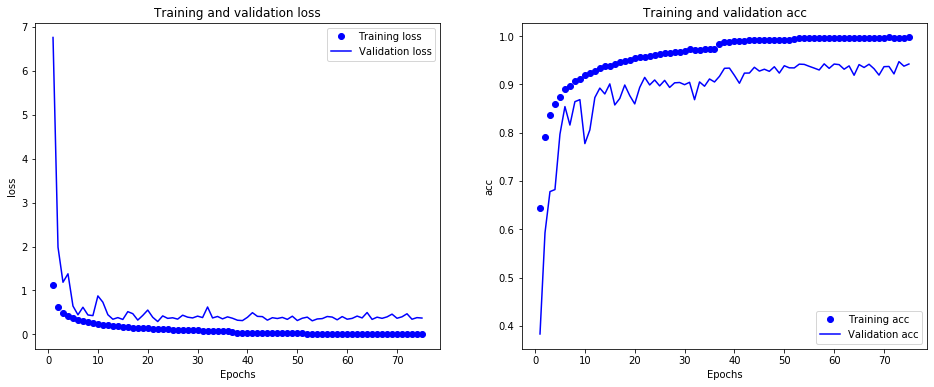

In [16]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
%matplotlib inline
epochs = range(1, len(history.history['loss']) + 1)

rows, cols = 1, 2
figure, ax = plt.subplots(rows, cols, figsize=(16,6))

for i, metric in enumerate(['loss', 'acc']):
    plt.subplot(1, 2, i+1)
    plt.plot(epochs, history.history[metric], 'bo', label=f"Training {metric}")
    plt.plot(epochs, history.history['val_'+metric], 'b', label=f"Validation {metric}")
    plt.title(f"Training and validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()